# Fluxo de Kovasznay Inverso
---

In [1]:
import os
import re
os.environ['DDE_BACKEND'] = 'paddle'
import deepxde as dde
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# https://deepxde.readthedocs.io/en/latest/modules/deepxde.optimizers.html#module-deepxde.optimizers.config
dde.config.set_default_float("float64")

dde.config.set_random_seed(42)
np.random.seed(42)

which: no ccache in (/home/gabriel/anaconda3/envs/concap2025NSpinns/bin:/home/gabriel/anaconda3/condabin:/home/gabriel/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/bin:/usr/lib/jvm/default/bin:/usr/bin/site_perl:/usr/bin/vendor_perl:/usr/bin/core_perl:/home/gabriel/.dotnet/tools)
/home/gabriel/anaconda3/envs/concap2025NSpinns/lib/python3.13/site-packages/paddle/utils/cpp_extension/extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Using backend: paddle
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, jax.
paddle supports more examples now and is recommended.


Set the default float type to float64


## Problema inverso

Por se tratar de um problema inverso, em que queremos descobrir o número de Reynolds que gerou os dados disponíveis, definimos um chute inicial e atribuímos a uma variável que terá seu valor modificado ao longo do treinamento da rede.

In [2]:
Re = 50

Re_guess = 10.0

ex_Re = dde.Variable(Re_guess)

## Residual

Definimos as equações de Navier-Stokes como um residual a ser minimizado.

In [3]:
def pde(x, y):
    
    u, v, p = y[:, 0:1], y[:, 1:2], y[:, 2:]
    
    du_dx = dde.grad.jacobian(y, x, i=0, j=0)
    du_dy = dde.grad.jacobian(y, x, i=0, j=1)
    
    dv_dx = dde.grad.jacobian(y, x, i=1, j=0)
    dv_dy = dde.grad.jacobian(y, x, i=1, j=1)
    
    du_dxx = dde.grad.hessian(y, x, i=0, j=0, component=0)
    du_dyy = dde.grad.hessian(y, x, i=1, j=1, component=0)
    
    dv_dxx = dde.grad.hessian(y, x, i=0, j=0, component=1)
    dv_dyy = dde.grad.hessian(y, x, i=1, j=1, component=1)

    dp_dx = dde.grad.jacobian(y, x, i=2, j=0)
    dp_dy = dde.grad.jacobian(y, x, i=2, j=1)

    momentum_x = (
        u * du_dx + v * du_dy + dp_dx - 1 / ex_Re * (du_dxx + du_dyy)
    )
    
    momentum_y = (
        u * dv_dx + v * dv_dy + dp_dy - 1 / ex_Re * (dv_dxx + dv_dyy)
    )
    
    continuity = du_dx + dv_dy

    return [momentum_x, momentum_y, continuity]

## Solução Exata

$$
\lambda = \frac{1}{2v} - \sqrt{\frac{1}{4v^{2}} + 4\pi^{2}}
$$

$$
u = 1 - e^{\lambda x} cos(2\pi y), \quad 
v = \frac{\lambda}{2\pi}e^{\lambda x}sin(2\pi y), \quad
p = \frac{1}{2}(1 - e^{2\lambda x})
$$

In [4]:
nu = 1 / Re
l = 1 / (2 * nu) - np.sqrt(1 / (4 * nu ** 2) + 4 * np.pi ** 2)

In [5]:
def u_sol(x):
    return 1 - np.exp(l * x[:, 0:1]) * np.cos(2 * np.pi * x[:, 1:2])

def v_sol(x):
    return l / (2 * np.pi) * np.exp(l * x[:, 0:1]) * np.sin(2 * np.pi * x[:, 1:2])

def p_sol(x):
    return 1 / 2 * (1 - np.exp(2 * l * x[:, 0:1]))

## Pertubação nos Dados

Adicionamos ruído gaussiano aos dados para testar a resiliência do método.

In [6]:
noise_percentage = 0.1

In [7]:
def get_noise(x):
    return noise_percentage * np.std(x) * np.random.normal(size=x.shape)

def noisy_u_sol(x):
    u = u_sol(x)
    return u + get_noise(u) 

def noisy_v_sol(x):
    v = v_sol(x)
    return v + get_noise(v)

def noisy_p_sol(x):
    p = p_sol(x)
    return p + get_noise(p)

## Condições de fronteira e dados

O problema será resolvido dentro de um retângulo: 
$$
-0.5 \leq x \leq 1, \qquad -0.5 \leq y \leq 1.5  
$$


In [8]:
x0, xf = -0.5, 1
y0, yf = -0.5, 1.5

In [9]:
def boundary_outflow(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], xf)

spatial_domain = dde.geometry.Rectangle(xmin=[x0, y0], xmax=[xf, yf])

u_bc = dde.icbc.DirichletBC(
    spatial_domain, u_sol, lambda _, on_boundary: on_boundary, component=0
)

v_bc = dde.icbc.DirichletBC(
    spatial_domain, v_sol, lambda _, on_boundary: on_boundary, component=1
)

right_p_bc = dde.icbc.DirichletBC(
    spatial_domain, p_sol, boundary_outflow, component=2
)

data_cp = spatial_domain.random_points(1000)

noisy_data_u = noisy_u_sol(data_cp)
noisy_data_v = noisy_v_sol(data_cp)
noisy_data_p = noisy_p_sol(data_cp)

noisy_data_u_bc = dde.icbc.PointSetBC(data_cp, noisy_data_u, component=0)
noisy_data_v_bc = dde.icbc.PointSetBC(data_cp, noisy_data_v, component=1)
noisy_data_p_bc = dde.icbc.PointSetBC(data_cp, noisy_data_p, component=2)

## Pontos de colocação

In [10]:
num_domain = 2048
num_boundary = 400
num_test = 512

In [11]:
noisy_data = dde.data.PDE(
    spatial_domain,
    pde,
    [
        u_bc, v_bc, right_p_bc,
        noisy_data_u_bc, noisy_data_v_bc, noisy_data_p_bc
    ],
    num_domain=num_domain,
    num_boundary=num_boundary,
    num_test=num_test,
    anchors=data_cp
)

## Definindo as configurações da rede

In [12]:
n_hidden_layers = 4
nodes_per_layer = 50
topology = [2] + n_hidden_layers * [nodes_per_layer] + [3]
activation = "tanh"
initialization = "Glorot normal"

net = dde.nn.FNN(topology, activation, initialization)

noisy_model = dde.Model(noisy_data, net)

## Treinando o modelo

In [13]:
adam_iterations = 60000

In [14]:
ex_variable_cb = dde.callbacks.VariableValue(
    [ex_Re], 
    period=1000, 
    filename=f"./parameters/Re{Re}.dat"
)

noisy_model.compile("adam", lr=1e-3, external_trainable_variables=[ex_Re])

losshistory, train_state = noisy_model.train(
    iterations=adam_iterations, 
    display_every=5000,
    callbacks=[ex_variable_cb])

Compiling model...
'compile' took 0.000236 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.40e-02, 5.64e-02, 2.35e-01, 2.92e+00, 8.72e-02, 1.05e-01, 1.87e+00, 5.39e-02, 9.30e-02]    [1.26e-02, 5.74e-02, 2.40e-01, 2.92e+00, 8.72e-02, 1.05e-01, 1.87e+00, 5.39e-02, 9.30e-02]    []  
5000      [9.34e-03, 7.71e-04, 1.27e-03, 1.24e-02, 1.24e-03, 1.00e-03, 4.45e-02, 2.37e-03, 9.74e-03]    [1.05e-02, 5.40e-04, 1.17e-03, 1.24e-02, 1.24e-03, 1.00e-03, 4.45e-02, 2.37e-03, 9.74e-03]    []  
10000     [6.23e-03, 4.29e-04, 9.29e-04, 6.77e-03, 5.87e-04, 6.97e-04, 2.54e-02, 1.14e-03, 7.05e-03]    [7.08e-03, 3.44e-04, 9.66e-04, 6.77e-03, 5.87e-04, 6.97e-04, 2.54e-02, 1.14e-03, 7.05e-03]    []  
15000     [3.90e-03, 2.77e-04, 4.64e-04, 4.04e-03, 4.46e-04, 4.49e-04, 1.57e-02, 5.86e-04, 4.44e-03]    [4.59e-03, 2

## Salvando o modelo

In [15]:
dde.saveplot(
    losshistory, 
    train_state, 
    issave=True, 
    isplot=False, 
    output_dir="./losses", 
    loss_fname=f"Re{Re}-loss",
    train_fname=f"Re{Re}-train",
    test_fname=f"Re{Re}-test")

noisy_model.save(f"./models/Re{Re}")

Saving loss history to ./losses/Re50-loss ...
Saving training data to ./losses/Re50-train ...
Saving test data to ./losses/Re50-test ...


'./models/Re50-60000.pdparams'

## Visualizando resultados

In [16]:

def plot_and_save_losses(losshistory, fig_name):
    
    X = losshistory.steps
    train = np.sum(losshistory.loss_train, axis=1)
    test = np.sum(losshistory.loss_test, axis=1)
    
    plt.semilogy(X, train, "o-", label="Treinamento", linewidth=2)
    plt.semilogy(X, test, "x-", label="Teste", linewidth=2)
    
    plt.xlabel("Iteração")
    plt.ylabel("Erro em escala logarítmica")
    
    plt.legend()
    plt.grid()
    plt.savefig(f"./images/{fig_name}.png")
    plt.show()


def plot_parameter_approximation(path, real_value, fig_name):
    
    def parse_line(line):
        match = re.match(r'(\S+)\s*\[(\S+)\]', line.strip())
        if match:
            return [float(x) for x in match.groups()]
        return None 
    
    with open(path, 'r') as f:
        parsed_data = [parse_line(line) for line in f if not line.startswith('#') and line.strip()]
        parsed_data = [x for x in parsed_data if x is not None]

    df = pd.DataFrame(parsed_data, columns=['x', 'y'])
    
    iterations = df['x'].values
    reynolds = df['y'].values
    
    plt.plot(iterations, reynolds, color="blue", linewidth=2, linestyle='--', marker="o", markersize=5, label=r"$Re$ estimado")
    plt.axhline(y=real_value, color='r', label=r"$Re$ real")
    
    plt.xlabel("iteração")
    plt.ylabel(r"$Re$")

    plt.grid()
    plt.legend()
    plt.savefig(f"./images/{fig_name}.png")
    plt.show()

def plot_3d_projection(surface, title):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.plot_surface(Y, X, surface, vmin=surface.min() * 2, cmap="viridis")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.savefig(f"./images/{title}-{Re}.png")
    plt.show()

### Valor estimado

In [17]:
ex_Re.cpu().numpy()

array(50.16742768)

### Gráficos

In [18]:
#noisy_model.restore(f"./models/Re{Re}-{adam_iterations + lbfgs_iterations}")

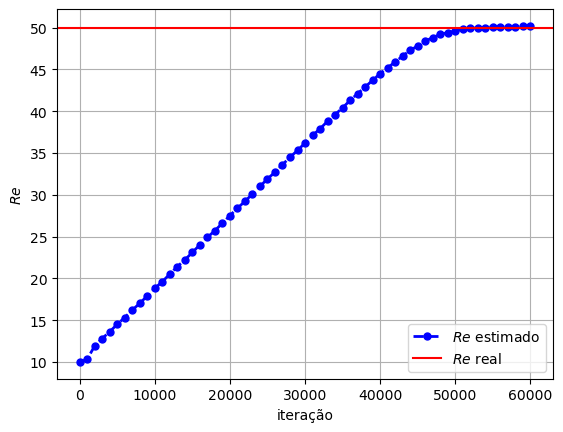

In [19]:
plot_parameter_approximation(f"./parameters/Re{Re}.dat", Re, f"Re{Re}-valores-re")

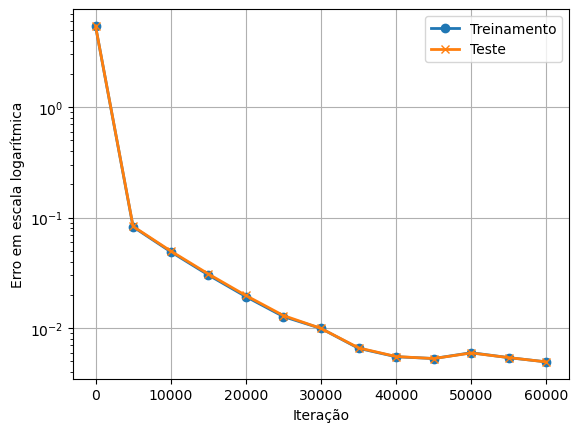

In [20]:
plot_and_save_losses(losshistory, f"Re{Re}-loss")

## Comparando resultados

### Visualizando superfícies

In [21]:
#noisy_model.restore(f"./models/Re{Re}-noisy-{adam_iterations + lbfgs_iterations}.pdparams")

In [22]:
nop = 100

X = np.linspace(-0.5, 1, nop)
Y = np.linspace(-0.5, 1.5, nop)

X, Y = np.meshgrid(X, Y)
XY = np.vstack((X.flatten(), Y.flatten())).T

In [23]:
predicted_values = noisy_model.predict(XY)

u_predicted = predicted_values[:,0].reshape((nop, nop))
v_predicted = predicted_values[:,1].reshape((nop, nop))
p_predicted = predicted_values[:,2].reshape((nop, nop))

In [24]:
u_real = u_sol(XY).reshape((nop, nop))
u_noisy = noisy_u_sol(XY).reshape((nop, nop))

v_real = v_sol(XY).reshape((nop, nop))
v_noisy = noisy_v_sol(XY).reshape((nop, nop))

p_real = p_sol(XY).reshape((nop, nop))
p_noisy = noisy_p_sol(XY).reshape((nop, nop))

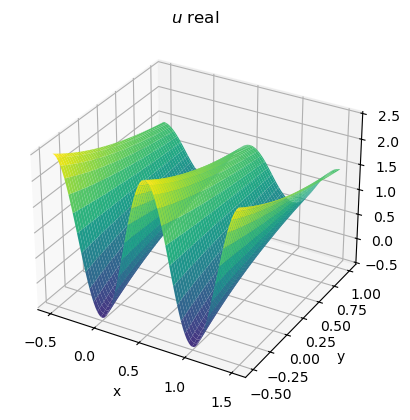

In [25]:
plot_3d_projection(u_real, r"$u$ real")

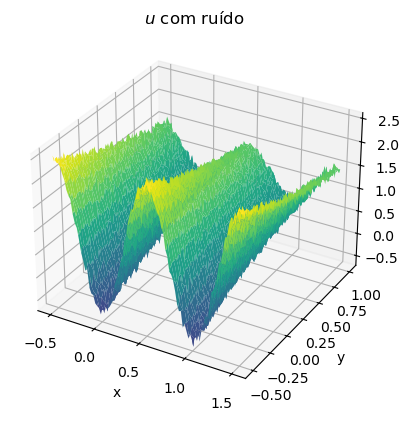

In [26]:
plot_3d_projection(u_noisy, r"$u$ com ruído")

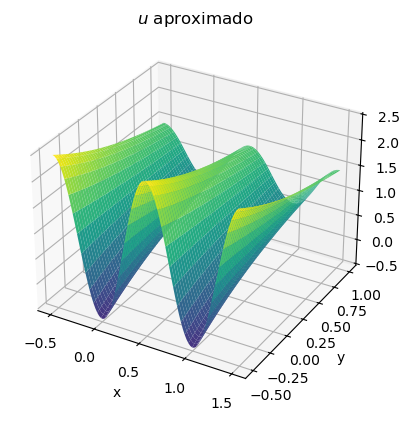

In [27]:
plot_3d_projection(u_predicted, r"$u$ aproximado")

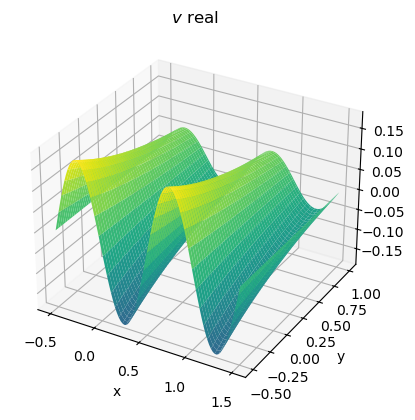

In [28]:
plot_3d_projection(v_real, r"$v$ real")

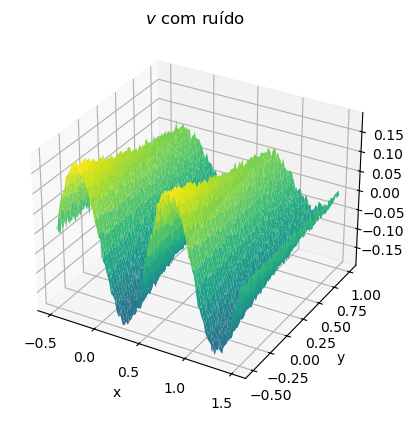

In [29]:
plot_3d_projection(v_noisy, r"$v$ com ruído")

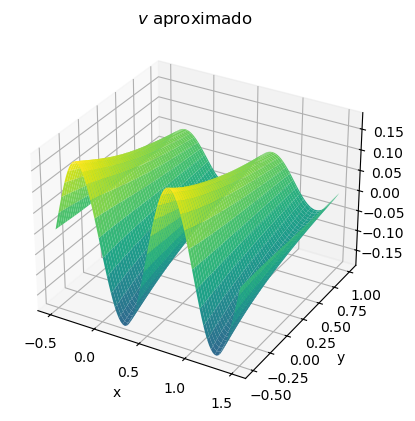

In [30]:
plot_3d_projection(v_predicted, r"$v$ aproximado")

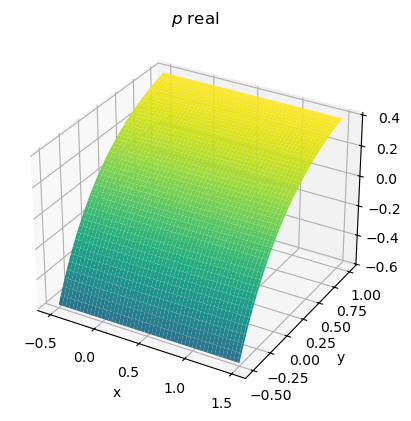

In [31]:
plot_3d_projection(p_real, r"$p$ real")

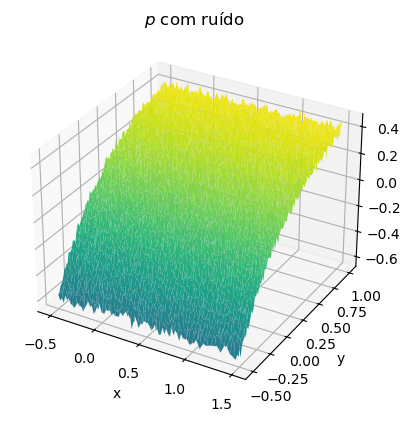

In [32]:
plot_3d_projection(p_noisy, r"$p$ com ruído")

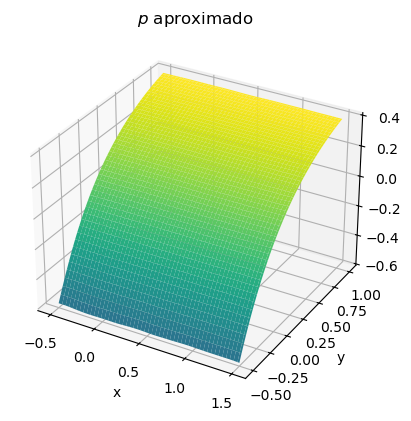

In [33]:
plot_3d_projection(p_predicted, r"$p$ aproximado")

## Métricas

### MSE

In [34]:
dde.metrics.mean_squared_error(u_real, u_predicted)

8.628306639116635e-06

In [35]:
dde.metrics.mean_squared_error(v_real, v_predicted)

1.0050066910310121e-06

In [36]:
dde.metrics.mean_squared_error(p_real, p_predicted)

1.97731809438477e-06

### MAPE

In [37]:
dde.metrics.mean_absolute_percentage_error(u_real, u_predicted)

np.float64(1.5575590365840584)

In [38]:
dde.metrics.mean_absolute_percentage_error(v_real, v_predicted)

np.float64(11518255557789.605)

In [39]:
dde.metrics.mean_absolute_percentage_error(p_real, p_predicted)

np.float64(6357482507544.288)

### Acurácia

In [40]:
dde.metrics.accuracy(u_real, u_predicted)

np.float64(0.99)

In [41]:
dde.metrics.accuracy(v_real, v_predicted)

np.float64(0.97)

In [42]:
dde.metrics.accuracy(p_real, p_predicted)

np.float64(1.0)

### L2

In [43]:
dde.metrics.l2_relative_error(u_real, u_predicted)

np.float64(0.0024439082835462744)

In [44]:
dde.metrics.l2_relative_error(v_real, v_predicted)

np.float64(0.012520094130029644)

In [45]:
dde.metrics.l2_relative_error(p_real, p_predicted)

np.float64(0.004913358907748688)

### L-Infinity

In [46]:
np.max(np.abs(u_real - u_predicted))

np.float64(0.01181880219785425)

In [47]:
np.max(np.abs(v_real - v_predicted))

np.float64(0.004810040469374629)

In [48]:
np.max(np.abs(p_real - p_predicted))

np.float64(0.008634854765820488)